# Cosinor Regression Model used for 24-hours Window Analysis

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.ma import add
from CosinorPy import file_parser, cosinor, cosinor1, cosinor_nonlin
np.seterr(divide='ignore')
import scipy.signal as signal
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as multi
from scipy.optimize import curve_fit
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from scipy.stats import percentileofscore
from scipy.stats import circstd, circmean

import copy
import itertools
from random import sample
import os
import copy
from CosinorPy.helpers import df_add_row

### Data Preparation

In [6]:
def load_data(path):
    """Function used to parser the data using the file_parser method from the CosinorPy package"""
    df = pd.read_csv(path)
    df['Region start time'] = pd.to_datetime(df['Region start time'])
    df['date'] = df['Region start time'].dt.date
    df['hour'] = df['Region start time'].dt.hour
    df = df.drop('Unnamed: 0', axis=1)
    return df

In [7]:
pre_data = load_data("data/RNS_G_Pre_output.csv")
post_data = load_data("data/RNS_G_M1_output.csv")

In [66]:
def prepare_data(df):
    """Function used to prepare the data for Cosinor Regression"""
    df1 = df.copy()
    df1["test"] = df1["date"].astype(str)
    df1["x"] = df1["hour"]
    df1["y"] = df1["Pattern A Channel 2"]

    return df1

/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


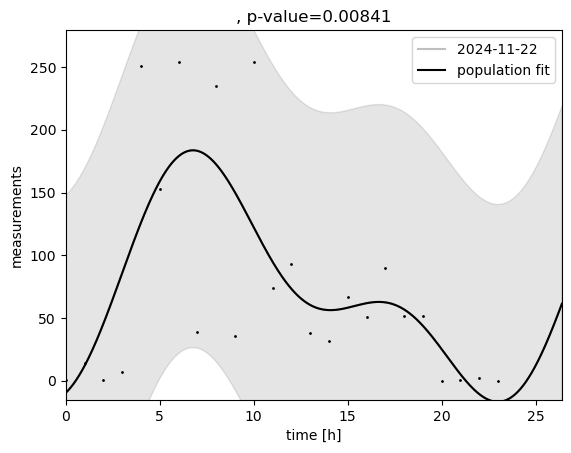

/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


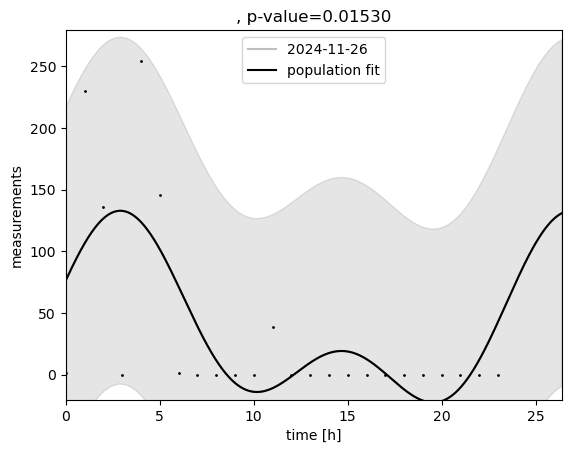

/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


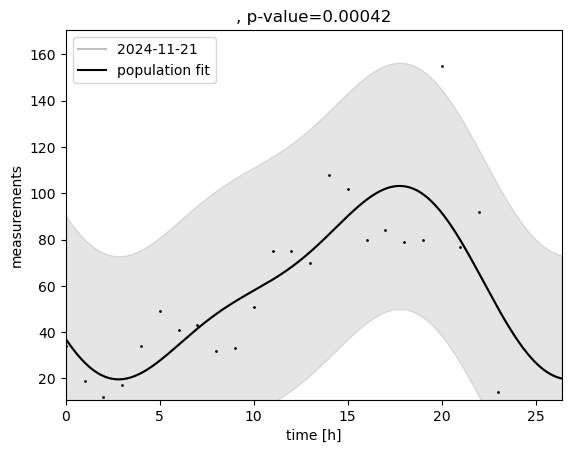

/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


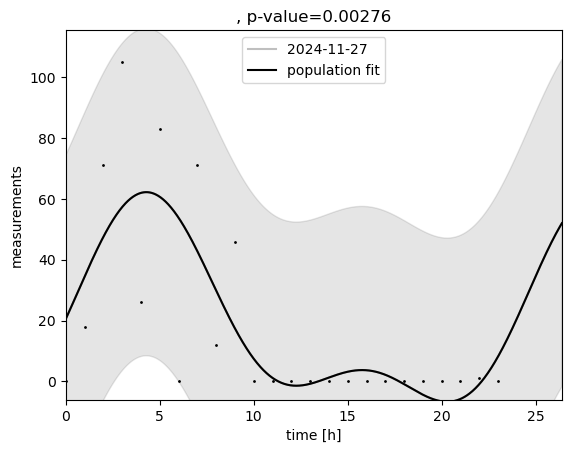

/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


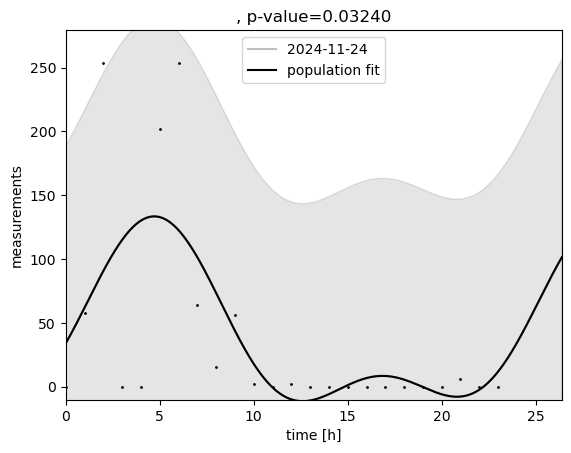

/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


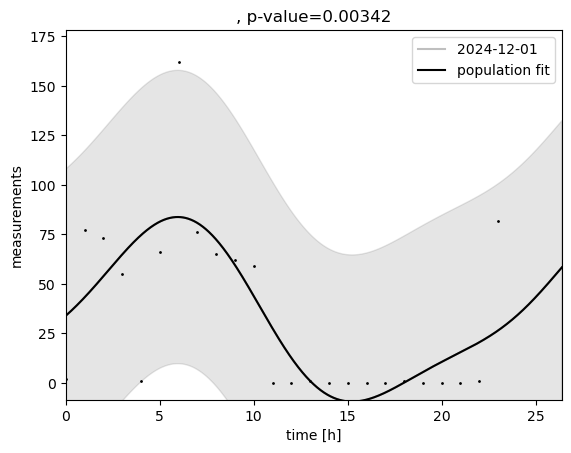

/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


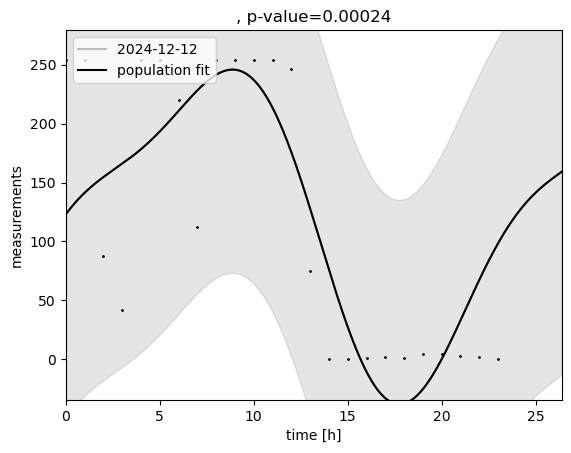

/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


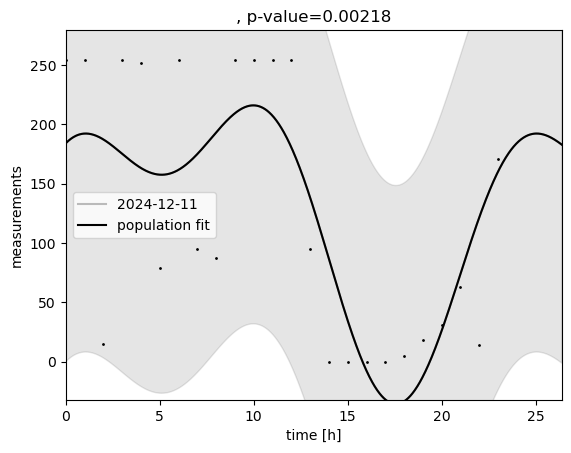

/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


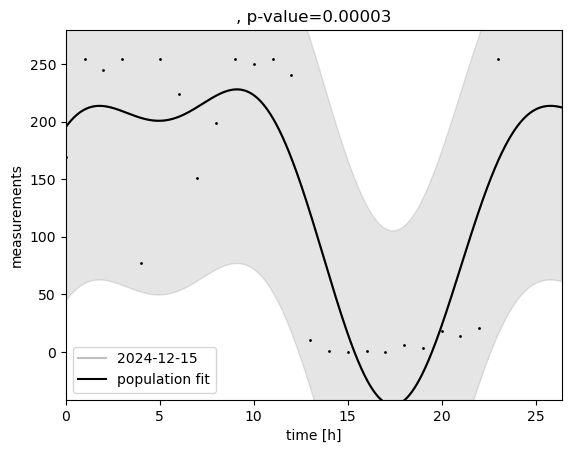

/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


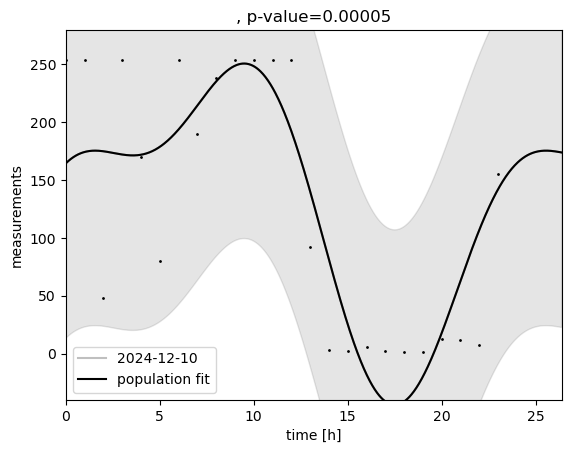

/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


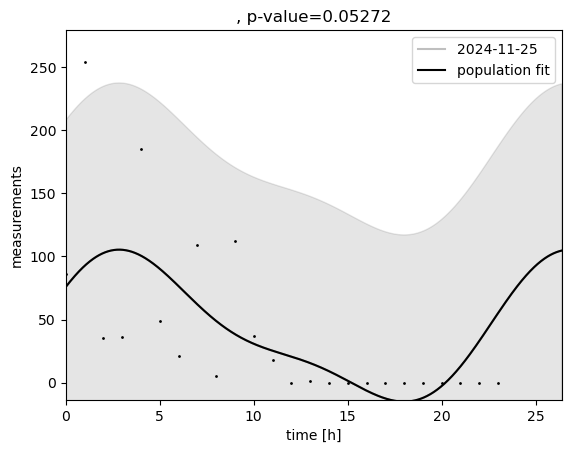

/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


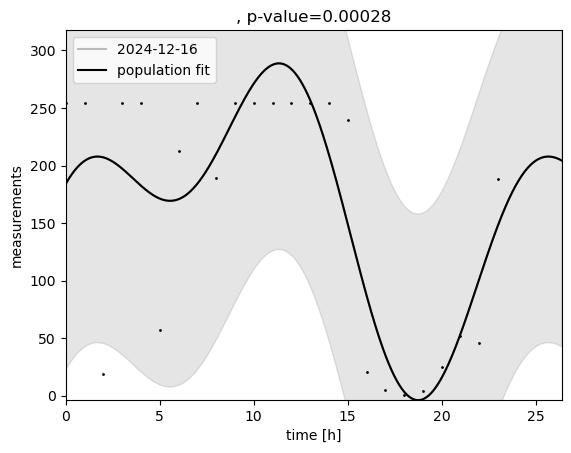

/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


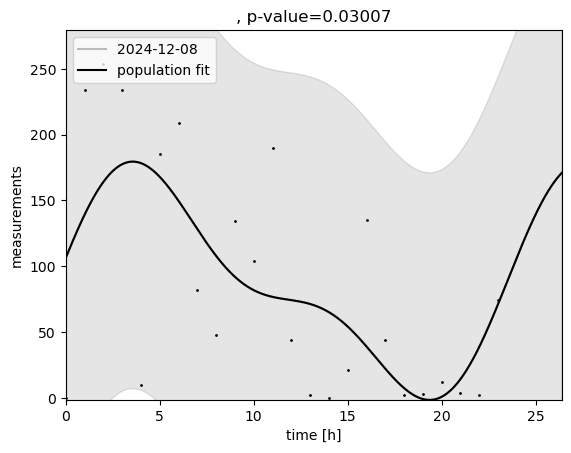

/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


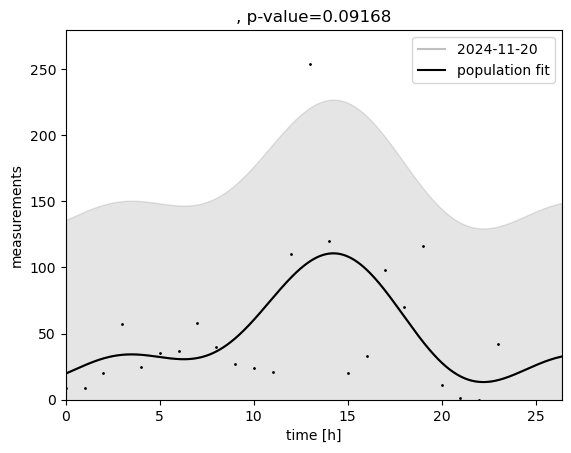

/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


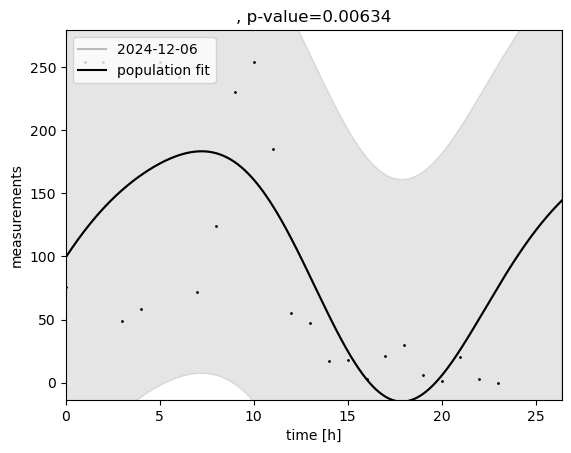

/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


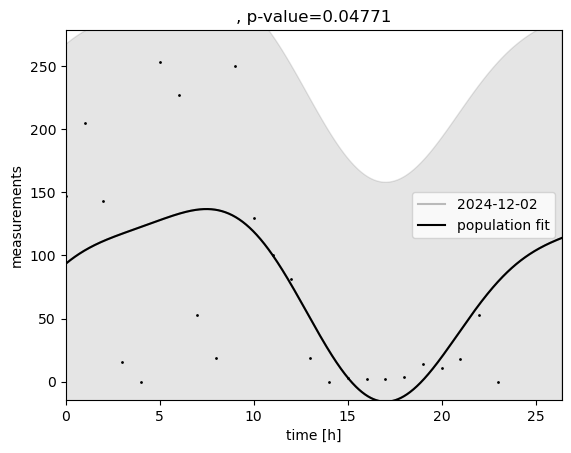

/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


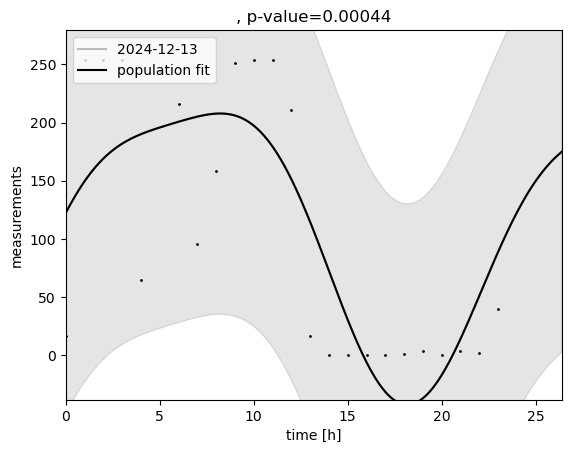

/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


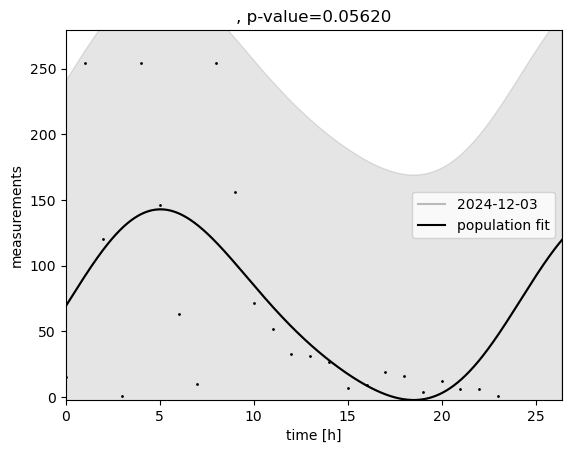

/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


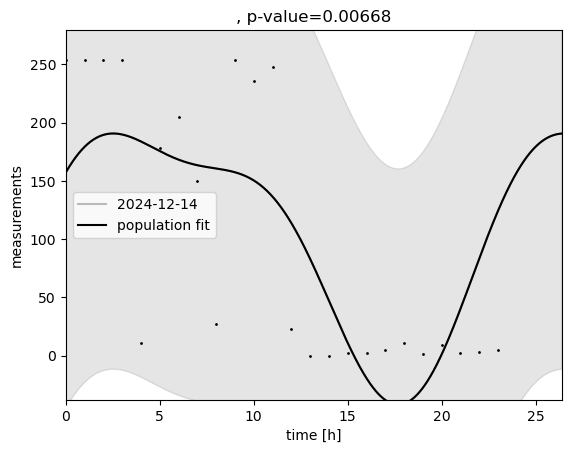

/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


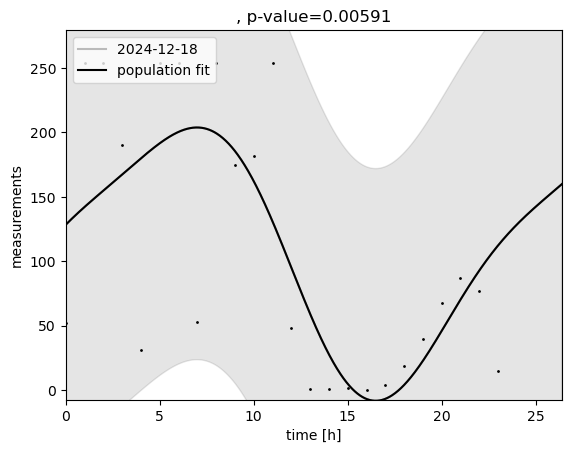

/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


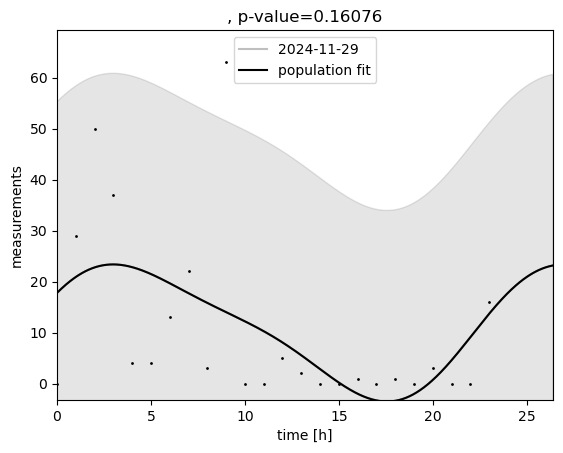

/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


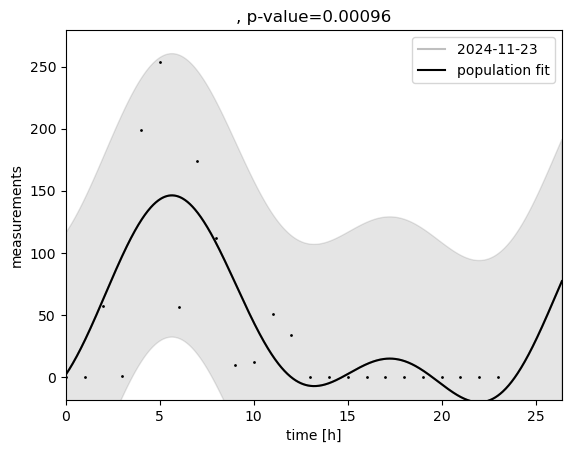

/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


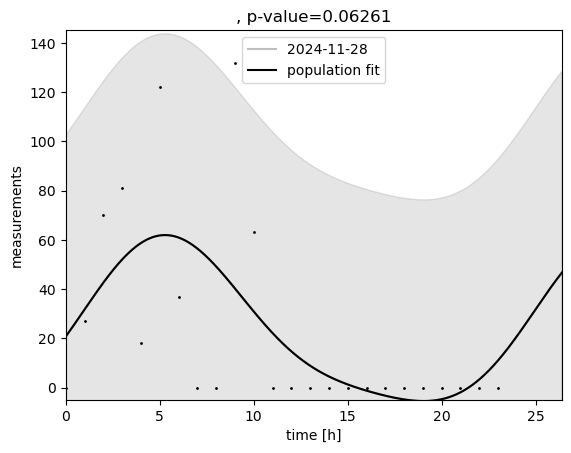

/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


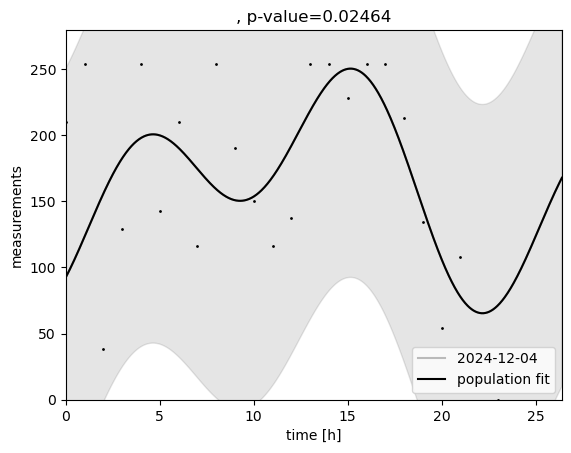

/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


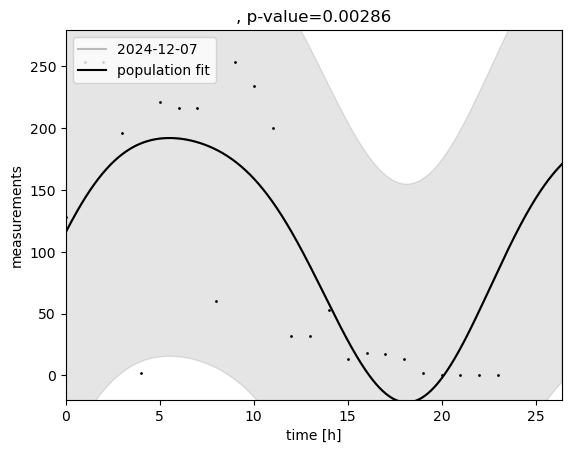

/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


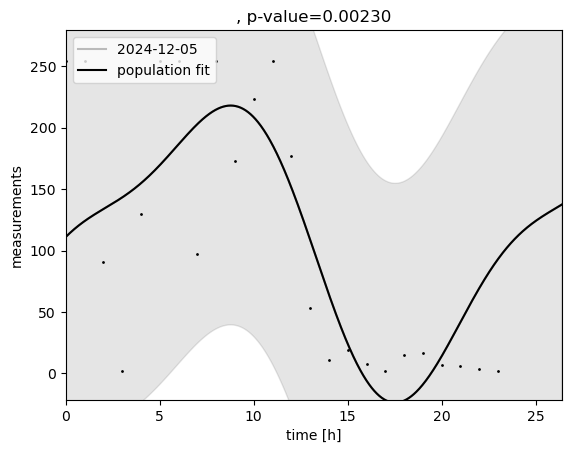

/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


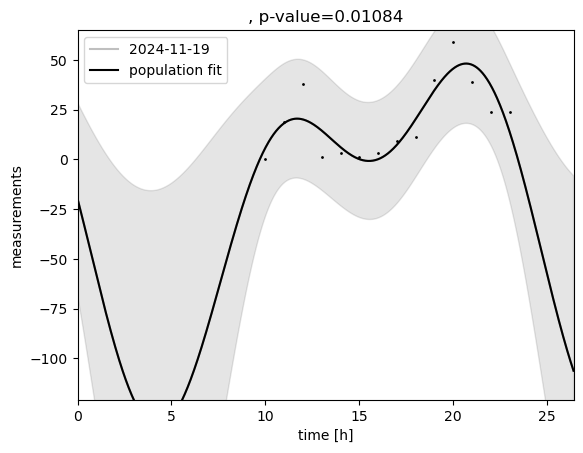

/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


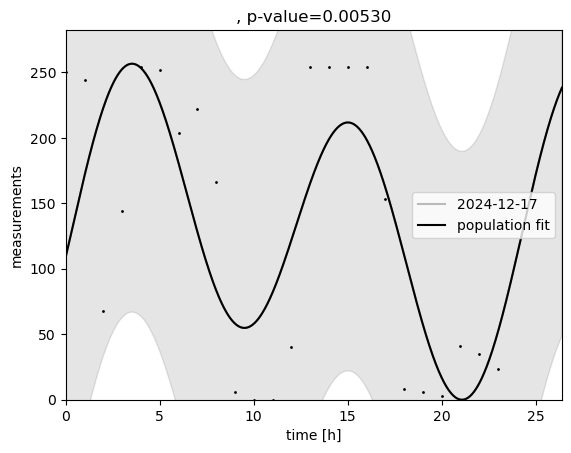

/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


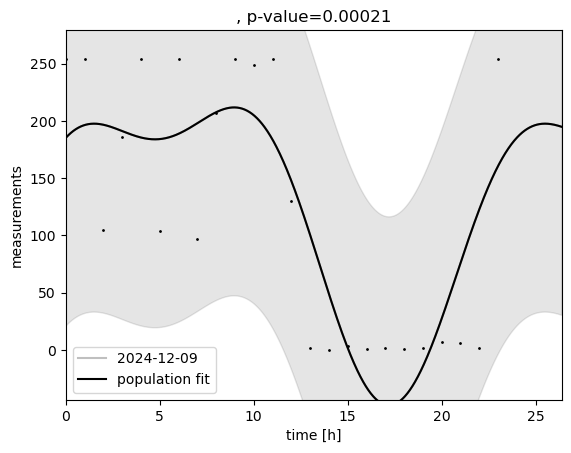

/opt/anaconda3/lib/python3.12/site-packages/CosinorPy/cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


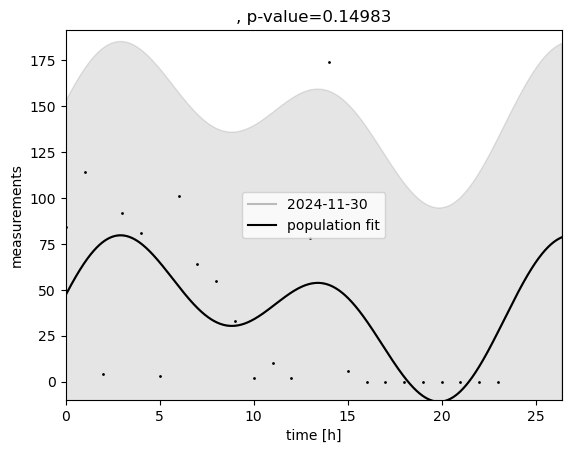

,test,period,n_components,p,q,p_reject,q_reject,RSS,amplitude,acrophase,...,resid_SE,mean(amplitude),p(amplitude),CI(amplitude),mean(acrophase),p(acrophase),CI(acrophase),mean(mesor),p(mesor),CI(mesor)
0,2024-11-19,24.0,2.0,0.010843,0.017121,NaN,NaN,1199.428355,91.121130,0.874237,...,11.544255,91.121130,NaN,"[nan, <function nan_to_num at 0x120c725c0>]",0.874237,NaN,"[nan, <function nan_to_num at 0x120c725c0>]",-43.011645,NaN,"[nan, <function nan_to_num at 0x120c725c0>]"
1,2024-11-20,24.0,2.0,0.091678,0.098226,NaN,NaN,48436.803925,48.659851,2.559816,...,50.490647,48.659851,NaN,"[nan, <function nan_to_num at 0x120c725c0>]",2.559816,NaN,"[nan, <function nan_to_num at 0x120c725c0>]",62.005468,NaN,"[nan, <function nan_to_num at 0x120c725c0>]"
2,2024-11-21,24.0,2.0,0.000419,0.001881,NaN,NaN,10171.436826,41.786086,1.628974,...,23.137389,41.786086,NaN,"[nan, <function nan_to_num at 0x120c725c0>]",1.628974,NaN,"[nan, <function nan_to_num at 0x120c725c0>]",61.385892,NaN,"[nan, <function nan_to_num at 0x120c725c0>]"
3,2024-11-22,24.0,2.0,0.008411,0.014018,NaN,NaN,88775.125623,100.210670,-1.773632,...,68.354773,100.210670,NaN,"[nan, <function nan_to_num at 0x120c725c0>]",-1.773632,NaN,"[nan, <function nan_to_num at 0x120c725c0>]",83.425373,NaN,"[nan, <function nan_to_num at 0x120c725c0>]"
4,2024-11-23,24.0,2.0,0.000956,0.003585,NaN,NaN,46777.337439,83.312033,-1.471737,...,49.618194,83.312033,NaN,"[nan, <function nan_to_num at 0x120c725c0>]",-1.471737,NaN,"[nan, <function nan_to_num at 0x120c725c0>]",62.988380,NaN,"[nan, <function nan_to_num at 0x120c725c0>]"
5,2024-11-24,24.0,2.0,0.032400,0.042261,NaN,NaN,86067.067747,72.419380,-1.232737,...,67.304128,72.419380,NaN,"[nan, <function nan_to_num at 0x120c725c0>]",-1.232737,NaN,"[nan, <function nan_to_num at 0x120c725c0>]",60.998618,NaN,"[nan, <function nan_to_num at 0x120c725c0>]"
6,2024-11-25,24.0,2.0,0.052718,0.063262,NaN,NaN,62657.134932,60.225012,-0.742158,...,57.425987,60.225012,NaN,"[nan, <function nan_to_num at 0x120c725c0>]",-0.742158,NaN,"[nan, <function nan_to_num at 0x120c725c0>]",45.179801,NaN,"[nan, <function nan_to_num at 0x120c725c0>]"
7,2024-11-26,24.0,2.0,0.015295,0.022943,NaN,NaN,71011.923115,77.736678,-0.754737,...,61.134848,77.736678,NaN,"[nan, <function nan_to_num at 0x120c725c0>]",-0.754737,NaN,"[nan, <function nan_to_num at 0x120c725c0>]",55.177310,NaN,"[nan, <function nan_to_num at 0x120c725c0>]"
8,2024-11-27,24.0,2.0,0.002763,0.007143,NaN,NaN,10391.147945,34.458601,-1.119527,...,23.385947,34.458601,NaN,"[nan, <function nan_to_num at 0x120c725c0>]",-1.119527,NaN,"[nan, <function nan_to_num at 0x120c725c0>]",27.770776,NaN,"[nan, <function nan_to_num at 0x120c725c0>]"
9,2024-11-28,24.0,2.0,0.062606,0.069562,NaN,NaN,23984.621141,33.715018,-1.383684,...,35.529544,33.715018,NaN,"[nan, <function nan_to_num at 0x120c725c0>]",-1.383684,NaN,"[nan, <function nan_to_num at 0x120c725c0>]",28.240628,NaN,"[nan, <function nan_to_num at 0x120c725c0>]"


In [69]:
df_results = cosinor.population_fit_group(prepare_data(pre_data))
df_best_models = cosinor.get_best_models(prepare_data(pre_data), df_results, n_components = [1,2,3])
df_best_models